In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import estimate_displacement as ed

from numpy.fft import fft2, ifft2, fftshift, ifftshift # Python DFT
import pywt

from ibllib.io import spikeglx

from yass import read_config, set_config
from yass.reader import READER
from yass.config import Config

from scipy.ndimage import gaussian_filter1d

In [2]:
geomarray = np.load("/mnt/1TB/joon/sawtell_primate/geom.npy")

## Define reader 
unregistered_path = "/mnt/1TB/joon/sawtell_primate/primate.bin"
fname_config = '/mnt/1TB/joon/sawtell_primate/drift.yaml'
CONFIG = set_config(fname_config, 'alltmp')

n_chan = CONFIG.recordings.n_channels

reader = READER(unregistered_path, 'int16', CONFIG, n_sec_chunk = 1)

/media/peter/2TB/hyundong/yass/src/yass/config/config.py:133: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  mapping = yaml.load(file)
/media/peter/2TB/hyundong/yass/src/yass/config/validate.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  schema = yaml.load(file)


In [3]:
total_shift = ed.estimate_displacement(reader, geomarray, 
                                       reader_type='yass', 
                                       num_chans_per_spike=2, 
                                       reg_win_num=1, 
                                       reg_block_num=1)

100%|██████████| 5416/5416 [03:00<00:00, 30.02it/s]


estimated sigma: 0.051365887830233894
plotting...



plotting...



plotting...



plotting...



plotting...



In [4]:
# output of estimate_displacement saved in total_shift.npy
#total_shift= np.load('total_shift.npy')

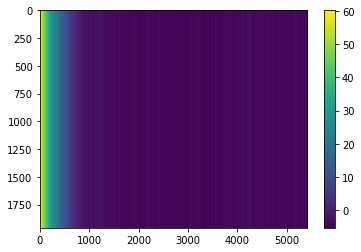

In [19]:
plt.imshow(total_shift, aspect='auto')
plt.colorbar()
plt.show()

In [7]:
ed.register(reader, geomarray, total_shift, reader_type='yass', registration_type='rigid')

100%|██████████| 5416/5416 [07:17<00:00, 12.37it/s]


In [8]:
geomarray = np.load("/mnt/1TB/joon/sawtell_primate/geom.npy")

## Define reader 
unregistered_path = "/media/peter/2TB/hyundong/spike_detection/registered/standardized.bin"
fname_config = '/media/peter/2TB/hyundong/spike_detection/drift.yaml'
CONFIG = set_config(fname_config, 'alltmp')

n_chan = CONFIG.recordings.n_channels

reader = READER(unregistered_path, 'float32', CONFIG, n_sec_chunk = 1)

In [9]:
output_directory = os.path.join('.', "spikes")
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
# detection + deduplication
# ts: a raw data batch of size (sampling frequency, n_channels) int16
# test on last 1500 seconds
n_batches = reader.n_batches
for i in tqdm(range(n_batches)):
    ts = reader.read_data_batch(i)
    ed.run_spike_detect(ts, geomarray, output_directory, i)

100%|██████████| 5416/5416 [36:17<00:00,  2.49it/s]


In [10]:
depths, times, amps, widths = ed.gen_raster_info(output_directory, num_chans=2)

100%|██████████| 5416/5416 [01:07<00:00, 80.15it/s] 


In [ ]:
# load depths, times, amps, widths
# depths = np.load('depths.npy')
# times = np.load('times.npy')
# amps = np.load('amps.npy')
# widths = np.load('widths.npy')

In [11]:
raster = ed.gen_raster(depths, times, amps, geomarray)

100%|██████████| 5416/5416 [03:45<00:00, 24.06it/s]


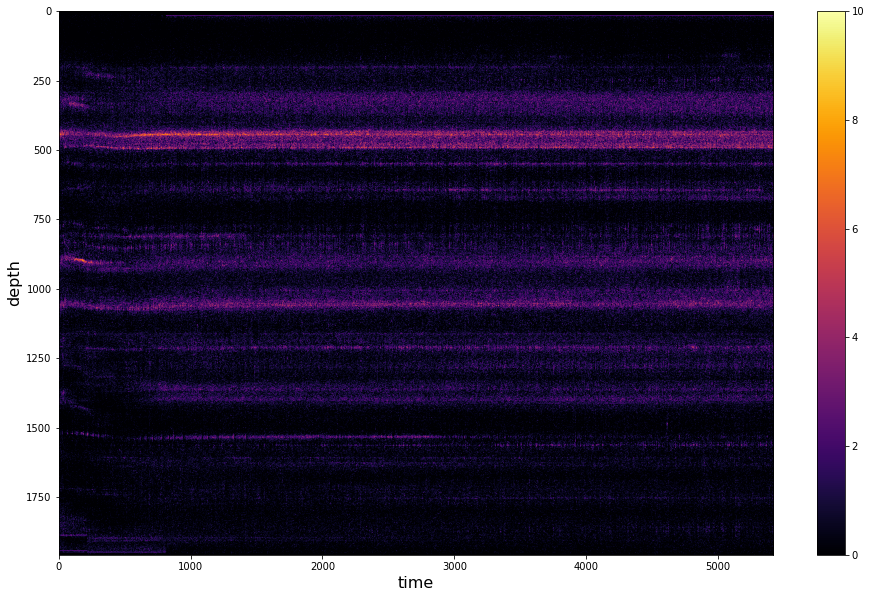

In [12]:
# view raster
plt.figure(figsize=(16, 10))
plt.imshow(raster, vmin=0, vmax=10, aspect="auto", cmap=plt.get_cmap('inferno'))
plt.ylabel("depth", fontsize=16)
plt.xlabel("time", fontsize=16)
plt.colorbar()
plt.show()

In [13]:
# destripe
destriped = ed.destripe(raster)

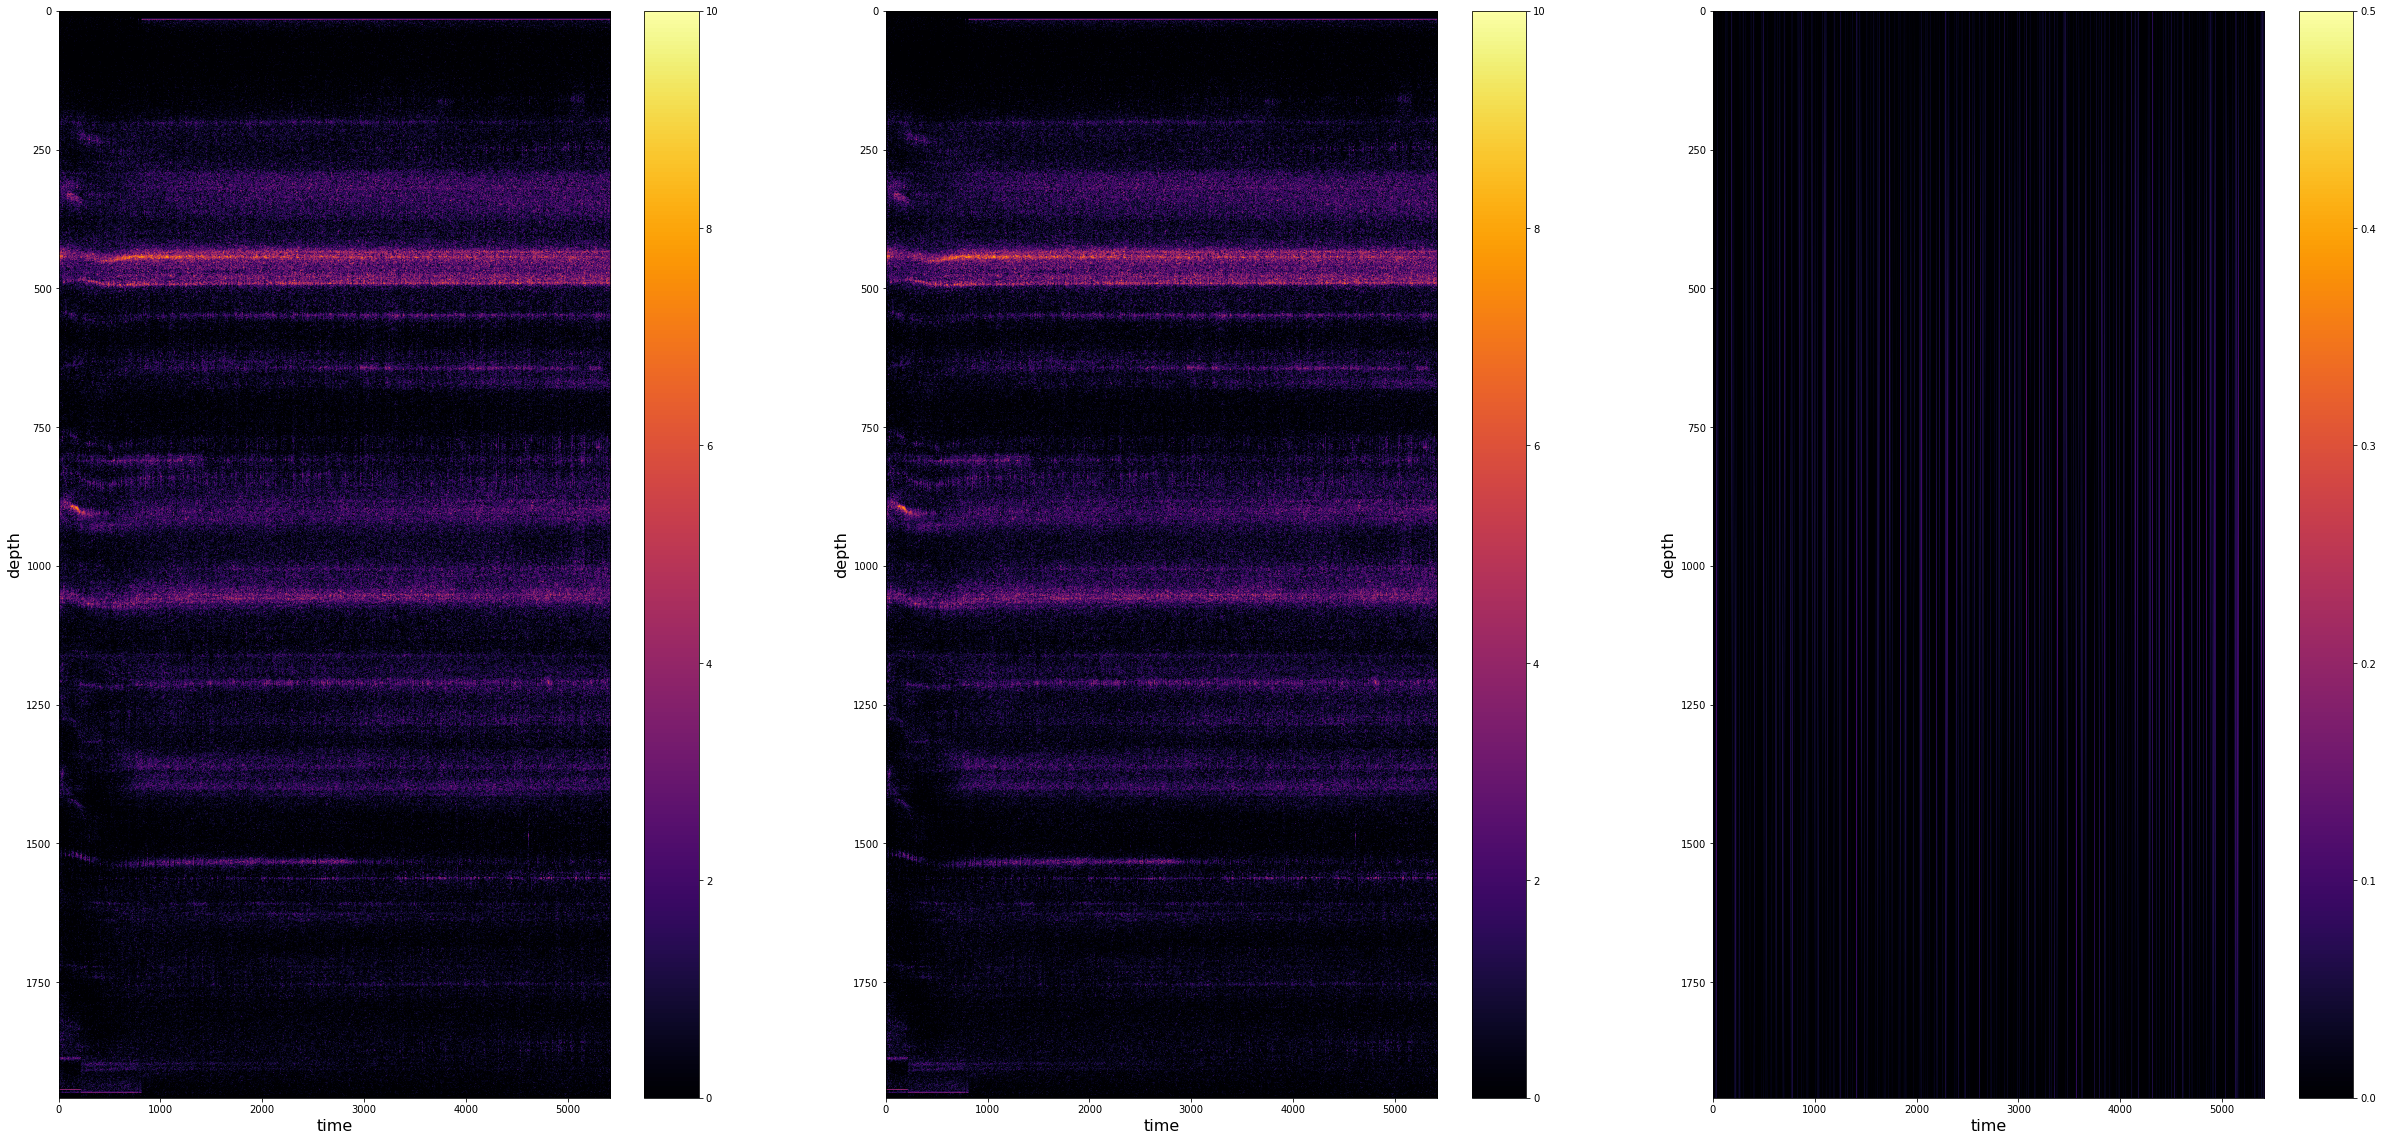

In [14]:
# view the effect of destriping
plt.figure(figsize=(42, 20))
plt.subplot(131)
plt.imshow(raster, vmin=0, vmax=10, aspect="auto", cmap=plt.get_cmap('inferno'))
plt.ylabel("depth", fontsize=16)
plt.xlabel("time", fontsize=16)
plt.colorbar()

plt.subplot(132)
plt.imshow(destriped, vmin=0, vmax=10, aspect="auto", cmap=plt.get_cmap('inferno'))
plt.ylabel("depth", fontsize=16)
plt.xlabel("time", fontsize=16)
plt.colorbar()

plt.subplot(133)
plt.imshow(raster-destriped, vmin=0, vmax=0.5, aspect="auto", cmap=plt.get_cmap('inferno'))
plt.ylabel("depth", fontsize=16)
plt.xlabel("time", fontsize=16)
plt.colorbar()

plt.show()

In [15]:
# denoise
denoised = ed.cheap_anscombe_denoising(destriped)

estimated sigma: 0.04685385332001446


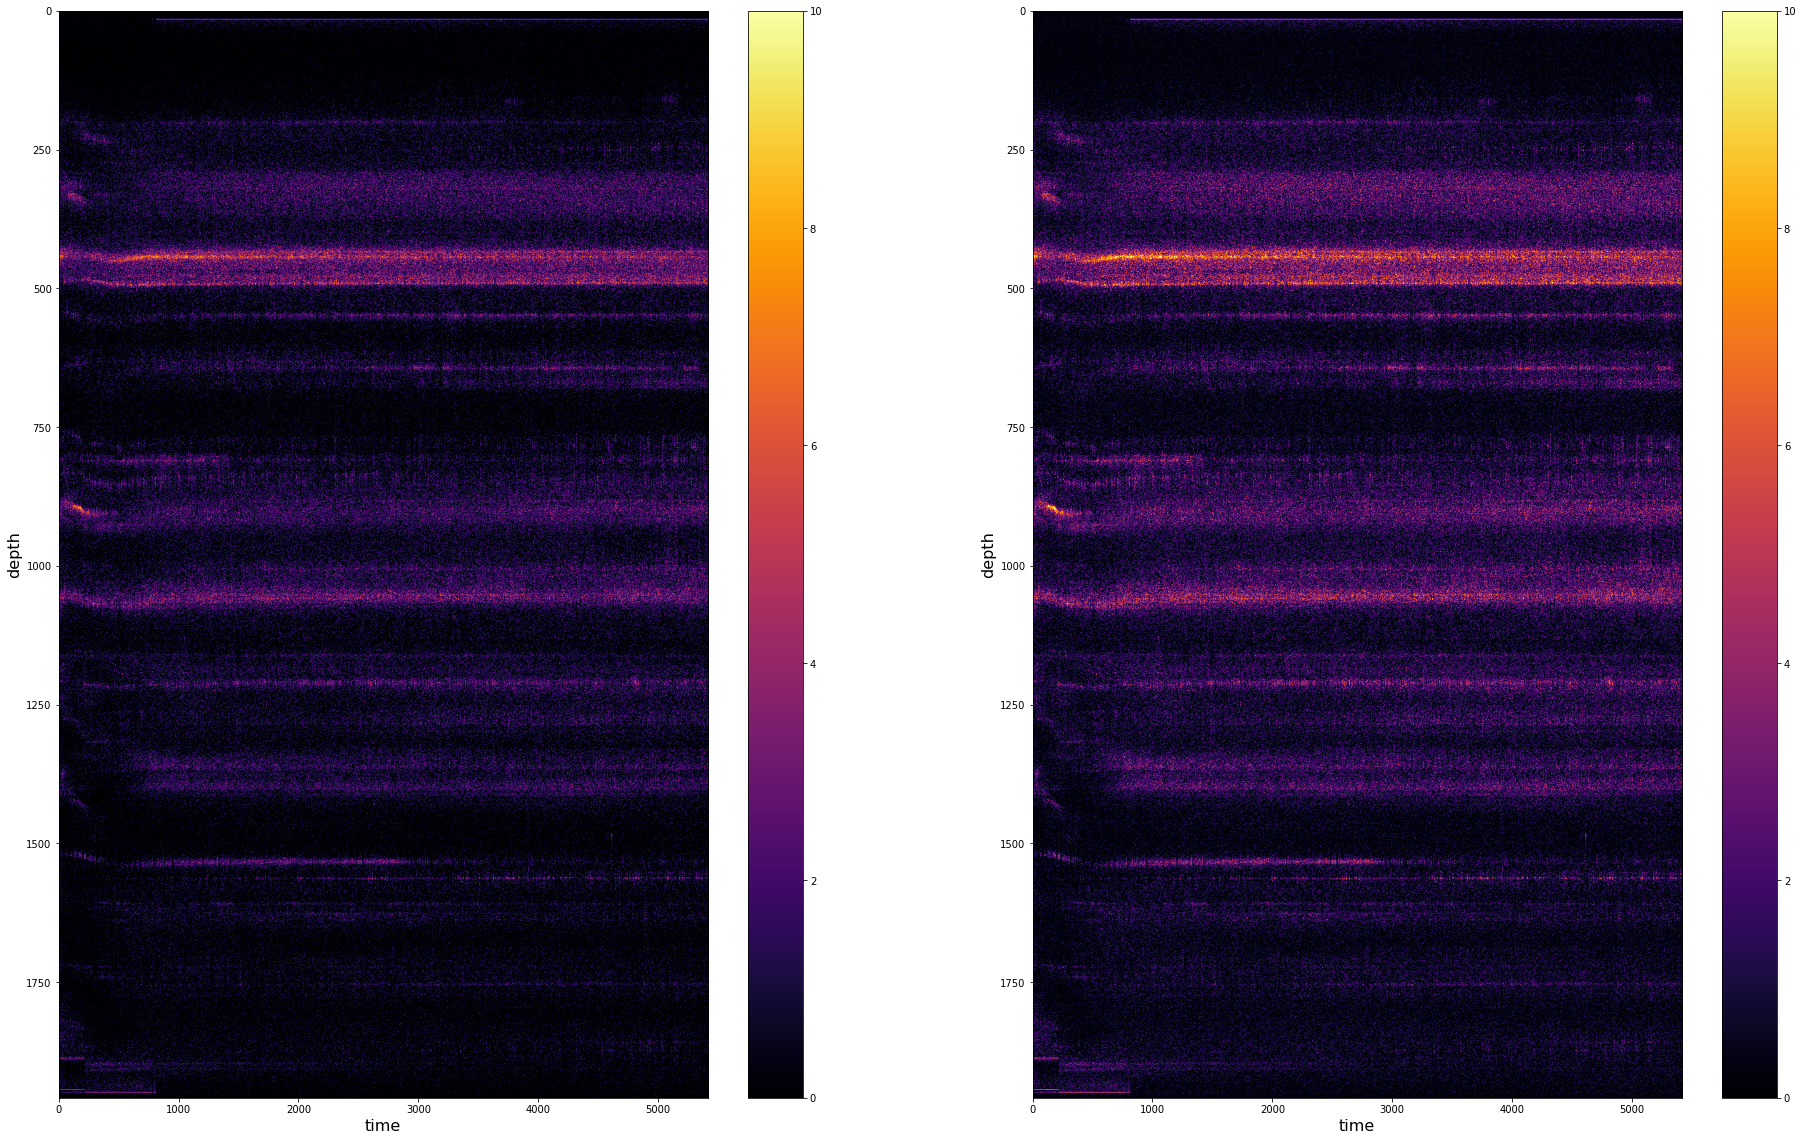

In [16]:
# view the effect of denoising
plt.figure(figsize=(32, 20))
plt.subplot(121)
plt.imshow(destriped, vmin=0, vmax=10, aspect="auto", cmap=plt.get_cmap('inferno'))
plt.ylabel("depth", fontsize=16)
plt.xlabel("time", fontsize=16)
plt.colorbar()

plt.subplot(122)
plt.imshow(denoised, vmin=0, vmax=10, aspect="auto", cmap=plt.get_cmap('inferno'))
plt.ylabel("depth", fontsize=16)
plt.xlabel("time", fontsize=16)
plt.colorbar()
plt.show()

In [20]:
# preprocess raw data
from preprocess import preprocess

In [23]:
preprocess(reader, run_adc_shift=False)

In [25]:
geomarray = np.load("/mnt/1TB/joon/sawtell_primate/geom.npy")

## Define reader 
unregistered_path = "/media/peter/2TB/hyundong/spike_detection/preprocessed_files/standardized.bin"
fname_config = '/media/peter/2TB/hyundong/spike_detection/drift.yaml'
CONFIG = set_config(fname_config, 'alltmp')

n_chan = CONFIG.recordings.n_channels

reader = READER(unregistered_path, 'float32', CONFIG, n_sec_chunk = 1)

In [26]:
output_directory = os.path.join('.', "spikes")
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
# detection + deduplication
# ts: a raw data batch of size (sampling frequency, n_channels) int16
# test on last 1500 seconds
n_batches = reader.n_batches
for i in tqdm(range(n_batches)):
    ts = reader.read_data_batch(i)
    ed.run_spike_detect(ts, geomarray, output_directory, i)

100%|██████████| 5416/5416 [43:18<00:00,  2.08it/s]


In [27]:
depths, times, amps, widths = ed.gen_raster_info(output_directory, num_chans=2)

100%|██████████| 5416/5416 [00:55<00:00, 97.44it/s] 


In [28]:
raster = ed.gen_raster(depths, times, amps, geomarray)

100%|██████████| 5416/5416 [03:20<00:00, 27.08it/s]


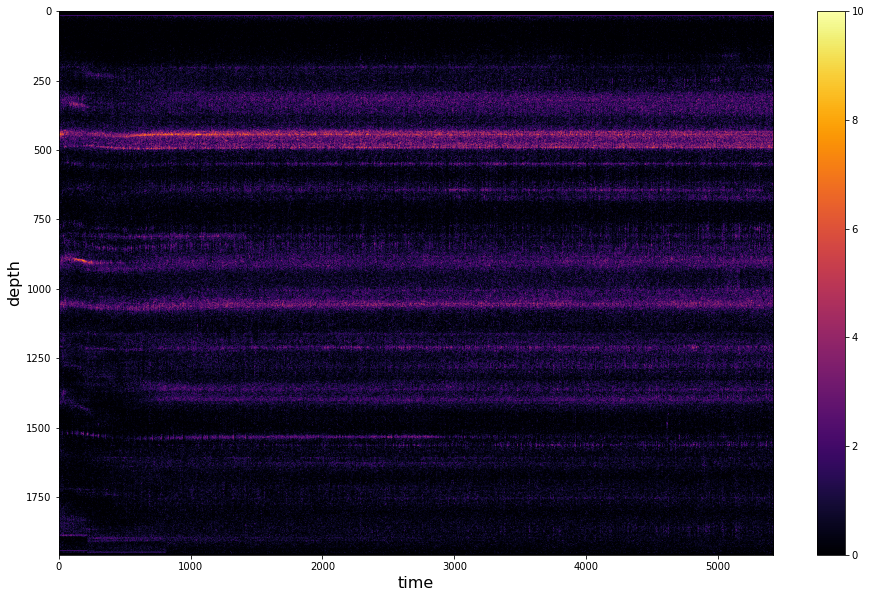

In [29]:
# view raster
plt.figure(figsize=(16, 10))
plt.imshow(raster, vmin=0, vmax=10, aspect="auto", cmap=plt.get_cmap('inferno'))
plt.ylabel("depth", fontsize=16)
plt.xlabel("time", fontsize=16)
plt.colorbar()
plt.show()